In [1]:
import pickle
import random
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
path_resultado = 'resultado_novo.dat'

with open(path_resultado, 'rb') as arquivo:
    pos_tag_per_genre = pickle.load(arquivo)

In [3]:
def evaluate(rate, genre):
    rate_per_genre = {'Action': 8, 'Drama': 9, 'Sci-Fi': 8, 'Horror': 7, 'Comedy': 8}
    return 'positive' if rate > rate_per_genre[genre] else 'negative'

def map_rate(rate, genre):
    map_rate_per_genre = {
        'Action': {'1': -5, '2': -4.38, '3': -3.75, '4': -3.13, '5': -2.5, '6': -1.88, '7': -1.25, '8': -0.63, '9': 2.5, '10': 5},
        'Drama': {'1': -5, '2': -4.44, '3': -3.89, '4': -3.33, '5': -2.78, '6': -2.22, '7': -1.67, '8': -1.11, '9': -0.56, '10': 5},
        'Horror': {'1': -5, '2': -4.29, '3': -3.57, '4': -2.86, '5': -2.14, '6': -1.43, '7': -0.71, '8': 1.67, '9': 3.33, '10': 5},
        'Sci-Fi': {'1': -5, '2': -4.38, '3': -3.75, '4': -3.13, '5': -2.5, '6': -1.88, '7': -1.25, '8': -0.63, '9': 2.5, '10': 5},
        'Comedy': {'1': -5, '2': -4.38, '3': -3.75, '4': -3.13, '5': -2.5, '6': -1.88, '7': -1.25, '8': -0.63, '9': 2.5, '10': 5}
    }
    
    return map_rate_per_genre[genre][str(rate)]

def find_word_sentiment(word_count, genre, mean):
    if word_count[0] < mean: return 0
    shift_per_genre = {'Action': 0.45, 'Horror': 0.325, 'Comedy': 0.725, 'Drama': 0.725, 'Sci-Fi': 0.075}
    ratings = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    total = word_count[0]
    sentiment = 0
    for rate in ratings:
        try:
            word_rate = word_count[rate]
        except:
            word_rate = 0
        
        sentiment += (word_rate/total) * map_rate(rate, genre)
    
    return sentiment - shift_per_genre[genre]

In [4]:
genres = ['Action', 'Comedy', 'Drama', 'Horror', 'Sci-Fi']
classes = ['ADJ', 'ADV', 'VERB', 'NOUN']

pos_tag_per_genre_final = {genre: {'rates': [], 'tag_text': []} for genre in genres}
for genre in genres:
    assert len(pos_tag_per_genre[genre]['tag_text']) == len(pos_tag_per_genre[genre]['rates'])
    n_reviews = len(pos_tag_per_genre[genre]['tag_text'])
    for i in range(n_reviews):
        review_clean = []
        review  = pos_tag_per_genre[genre]['tag_text'][i]
        rate    = pos_tag_per_genre[genre]['rates'][i]
        for word, sintax in review:
            if sintax in classes:
                review_clean.append((word, sintax))
                
        pos_tag_per_genre_final[genre]['rates'].append(rate)
        pos_tag_per_genre_final[genre]['tag_text'].append(review_clean)

In [5]:
train_test = {genre: {'train': {'rates': [], 'tag_text': []}, 'test': {'rates': [], 'tag_text': []}} for genre in genres}

for genre in genres:
    assert len(pos_tag_per_genre_final[genre]['tag_text']) == len(pos_tag_per_genre_final[genre]['rates'])
    n_reviews = len(pos_tag_per_genre_final[genre]['tag_text'])
    for i in range(n_reviews):
        review  = pos_tag_per_genre_final[genre]['tag_text'][i]
        rate    = pos_tag_per_genre_final[genre]['rates'][i]
        if random.random() < 0.2:
            train_test[genre]['test']['rates'].append(evaluate(rate, genre))
            train_test[genre]['test']['tag_text'].append(review)
        else:
            train_test[genre]['train']['rates'].append(rate)
            train_test[genre]['train']['tag_text'].append(review)

In [6]:
word_count_per_genre = {}
for genre in genres:
    word_count = {}
    assert len(train_test[genre]['train']['tag_text']) == len(train_test[genre]['train']['rates'])
    n_reviews = len(train_test[genre]['train']['tag_text'])
    for i in range(n_reviews):
        review  = train_test[genre]['train']['tag_text'][i]
        rate    = train_test[genre]['train']['rates'][i]
        for word in review:
            try:
                word_count[word][rate] += 1
                word_count[word][0] += 1
            except:
                word_count[word] = defaultdict(int)
                word_count[word][rate] += 1
                word_count[word][0] += 1
    word_count_per_genre[genre] = word_count

In [7]:
mean_per_genre = {}
for genre in genres:
    total = 0
    count = 0
    for word in word_count_per_genre[genre]:
        total += word_count_per_genre[genre][word][0]
        count += 1
    mean_per_genre[genre] = total/count

In [8]:
word_sentiment_per_genre = {genre: {} for genre in genres}

for genre in genres:
    for word in word_count_per_genre[genre]:
        word_sentiment_per_genre[genre][word] = find_word_sentiment(word_count_per_genre[genre][word], genre, mean_per_genre[genre])

In [9]:
x_expected = {genre: [] for genre in genres}
for genre in genres:
    for review in train_test[genre]['test']['tag_text']:
        reviews_rate = []
        review_rate = 0
        count = 0
        for word in review:
            count += 1
            try:
                sentiment = word_sentiment_per_genre[genre][word]
            except:
                sentiment = 0
            review_rate += sentiment
            reviews_rate.append(sentiment)
            
        if len(review) != 0:
            review_rate = review_rate/count
        if review_rate > 0:
            x_expected[genre].append('positive')
        else:
            x_expected[genre].append('negative')

In [10]:
for genre in genres:
    y_true = [1 if rate == 'positive' else 0 for rate in train_test[genre]['test']['rates']]
    y_pred = [1 if rate == 'positive' else 0 for rate in x_expected[genre]]
    precisao = accuracy_score(y_true, y_pred)
    acuracia = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    
    print(genre)
    print(f'Acurácia: {acuracia:.2f}')
    print(f'Precisão: {precisao:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F-score: {f_score:.2f}')

Action
Acurácia: 0.77
Precisão: 0.77
Recall: 0.82
F-score: 0.76
Comedy
Acurácia: 0.73
Precisão: 0.73
Recall: 0.80
F-score: 0.74
Drama
Acurácia: 0.74
Precisão: 0.74
Recall: 0.72
F-score: 0.69
Horror
Acurácia: 0.80
Precisão: 0.80
Recall: 0.84
F-score: 0.79
Sci-Fi
Acurácia: 0.78
Precisão: 0.78
Recall: 0.72
F-score: 0.72


In [11]:
for genre in genres:
    matriz_confusao = confusion_matrix(train_test[genre]['test']['rates'], x_expected[genre])
    print(f"Matriz de Confusão de {genre}:")
    print(matriz_confusao)

Matriz de Confusão de Action:
[[811 292]
 [164 742]]
Matriz de Confusão de Comedy:
[[718 358]
 [192 784]]
Matriz de Confusão de Drama:
[[894 304]
 [231 591]]
Matriz de Confusão de Horror:
[[800 254]
 [147 773]]
Matriz de Confusão de Sci-Fi:
[[973 216]
 [222 562]]


In [12]:
len_pos = 0
len_neg = 0
count_pos = 0
count_neg = 0
genre = 'Sci-Fi'
for i in range(10000):
    rate = pos_tag_per_genre_final[genre]['rates'][i]
    len_aval = len(pos_tag_per_genre_final[genre]['tag_text'][i])
    if rate > 8:
        len_pos += len_aval
        count_pos += 1
    else:
        len_neg += len_aval
        count_neg += 1
print(f'O tamanho médio das análises positivas pro gênero {genre} foi de: {len_pos/count_pos}')
print(f'O tamanho médio das análises negativas pro gênero {genre} foi de: {len_neg/count_neg}')

O tamanho médio das análises positivas pro gênero Sci-Fi foi de: 92.98413098236776
O tamanho médio das análises negativas pro gênero Sci-Fi foi de: 110.50514096185738


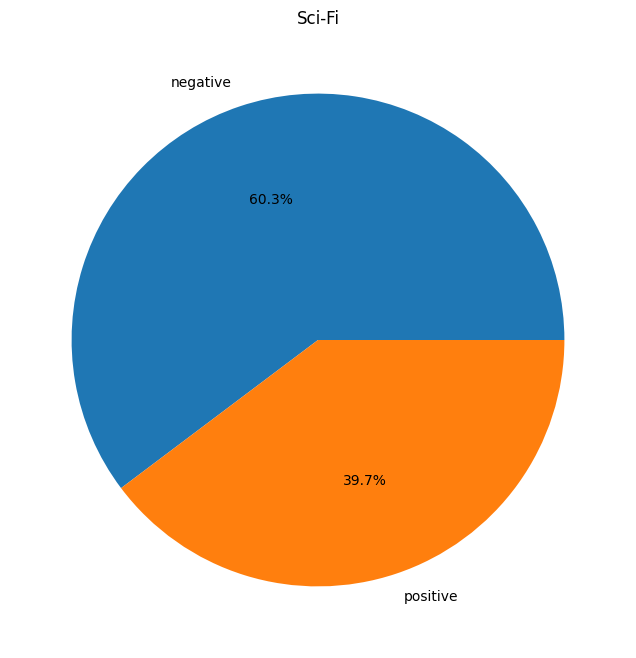

In [13]:
genre = 'Sci-Fi'
df = pd.DataFrame(train_test[genre]['test'])
value_counts = df['rates'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title(genre)
plt.show()